# Detour to Net Zero: A forecast of Canadian Greenhouse Gas Emissions Using RNN

### Background

As the climate crisis continues to worsen, with countries experiencing record high temperatures and increasing numbers of natural disasters, Canada has joined numerous other countries in proposing a ‘Net Zero’ commitment, pledging to reduce greenhouse gas (GHG) emissions 40-45% from 2005 levels by 2030 and achieving close to zero GHG emissions by 2050. 

Making promises and keeping them, however, are two entirely different things. For Canada to meet these ambitious goals, it will need to make significant changes to reduce the impact of its biggest polluting industries, who are responsible for the majority of GHG emissions in this country. The Canadian Net-Zero Emissions Accountability Act became law on June 29, 2021, and not much time has elapsed since then.

### Objective

This project attempts to forecast future CO2 emissions based on figures from three decades of emissions data from the Canadian Government by building a recurrent neural network (RNN) to analyze the trends from the data and make predictions forwards to 2030, to see just how close Canada will be to achieving its goals, should current trends hold. Three different model types are used - SimpleRNN, LSTM and GRU - and compared to determine which is the most suitable for the dataset.

Link to dataset: https://data.ec.gc.ca/data/substances/monitor/canada-s-official-greenhouse-gas-inventory/A-IPCC-Sector/?lang=en


In [372]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

sns.set()

In [100]:
# Import cleaned dataset

data = pd.read_csv('GHG_Canada_Clean_Real.csv')
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data = data.set_index('Year')
data.head()

,TOTAL,ENERGY,Stationary Combustion Sources,Public Electricity and Heat Production,Petroleum Refining Industries,Oil and Gas Extraction,Mining,Manufacturing Industries,Construction,Commercial and Institutional,...,Wastewater Treatment and Discharge,Incineration and Open Burning of Waste,Industrial Wood Waste Landfills,"LAND USE, LAND-USE CHANGE AND FORESTRY",Forest Land,Cropland,Grassland,Wetlands,Settlements,Harvested Wood Products
Year,,,,,,,,,,,,,,,,,,,,,
1990-01-01,594722,472162,277706,94519,17360,30758,4653,56164,1881,26199,...,1611,273,2869,-63537,-201919,379,1,5402,1894,130706
1991-01-01,587906,463670,273292,95899,16318,29336,4318,53930,1633,26842,...,1629,286,2973,-73607,-207052,-5975,1,5288,1853,132279
1992-01-01,605290,480873,282924,102404,16553,31209,3727,52964,1757,27499,...,1663,302,3063,-58916,-205117,-2861,1,5148,1662,142251
1993-01-01,607681,481966,277964,93163,17156,34399,4024,50778,1386,28498,...,1664,303,3142,-46630,-200787,1665,0,5487,1512,145492
1994-01-01,628146,498097,283371,95397,16146,35071,4580,54206,1396,27816,...,1727,337,3208,-55688,-201054,-8386,1,3297,1310,149144


In [101]:
# Create Main and Sub- Industry dataframes
main_industries = data[['ENERGY', 'INDUSTRIAL PROCESSES AND PRODUCT USE', 'AGRICULTURE', 'WASTE']]
energy = data['ENERGY']
industry = data['INDUSTRIAL PROCESSES AND PRODUCT USE']
agriculture = data['AGRICULTURE']
waste = data['WASTE']
energy_sub = data.iloc[:, 2:21]
industrial_sub = data.iloc[:, 22:28]
agriculture_sub = data.iloc[:, 29:34]
waste_sub = data.iloc[:, 35:40]

# Forestry industries are not counted against the GHG total and are left out

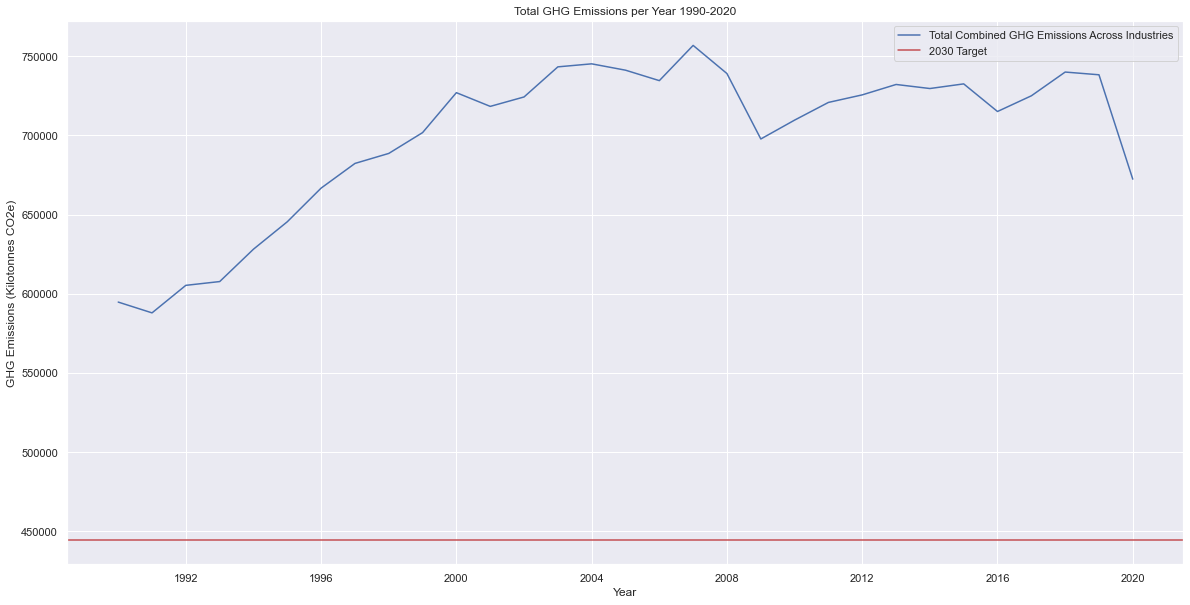

In [102]:
# Plotting current data

# Total

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data.TOTAL, label='Total Combined GHG Emissions Across Industries')
plt.axhline(y=(data.TOTAL[15]*0.60), color='r', linestyle = '-', label='2030 Target')
plt.title(label='Total GHG Emissions per Year 1990-2020')
ax.set_xlabel('Year')
ax.set_ylabel('GHG Emissions (Kilotonnes CO2e)')
plt.legend()
plt.show();

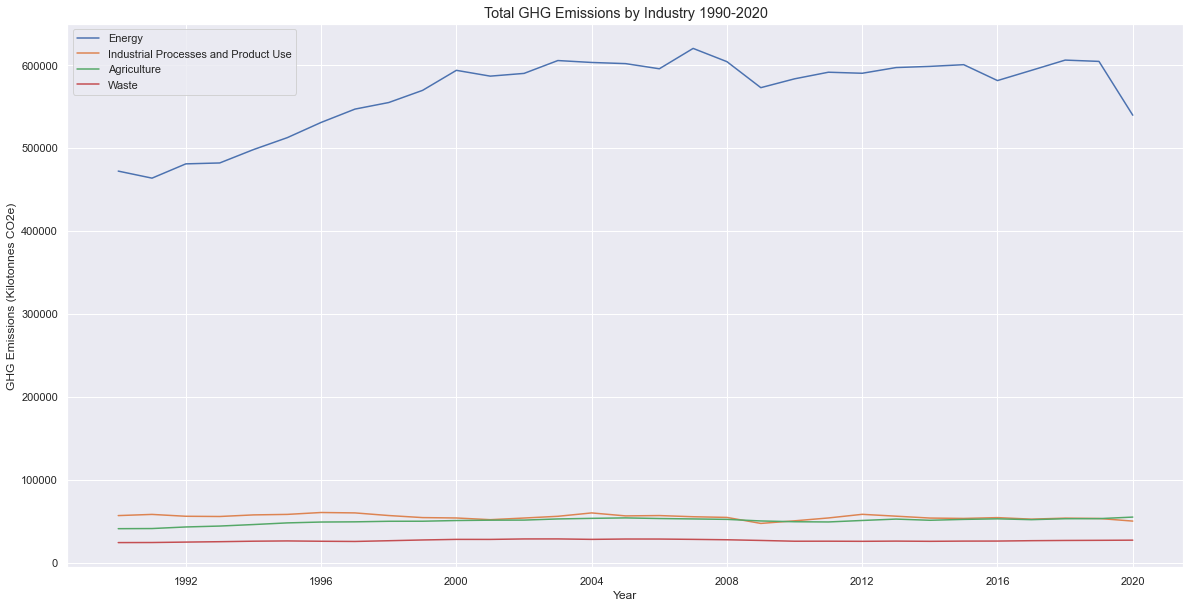

In [103]:
# Main Industries

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(main_industries.iloc[:, 0], label='Energy')
ax.plot(main_industries.iloc[:, 1], label='Industrial Processes and Product Use')
ax.plot(main_industries.iloc[:, 2], label='Agriculture')
ax.plot(main_industries.iloc[:, 3], label='Waste')
ax.set_xlabel('Year')
ax.set_ylabel('GHG Emissions (Kilotonnes CO2e)')
locs, labels = plt.xticks()
plt.legend()
plt.title(label='Total GHG Emissions by Industry 1990-2020', fontsize='large')
plt.show();

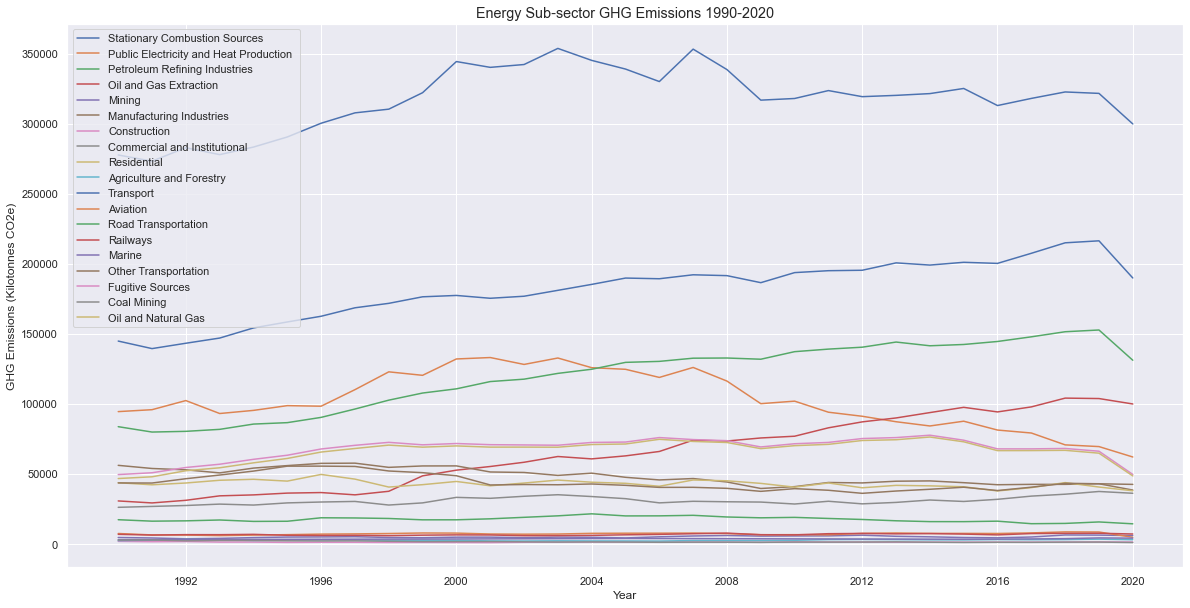

In [104]:
# Energy Sub-industries

fig, ax = plt.subplots(figsize=(20,10))
cols_en = list(energy_sub.columns)
for n in range(len(cols_en)):
    ax.plot(energy_sub.iloc[:, n], label=cols_en[n])
ax.set_xlabel('Year')
ax.set_ylabel('GHG Emissions (Kilotonnes CO2e)')
plt.legend()
plt.title(label='Energy Sub-sector GHG Emissions 1990-2020', fontsize='large')
plt.show();


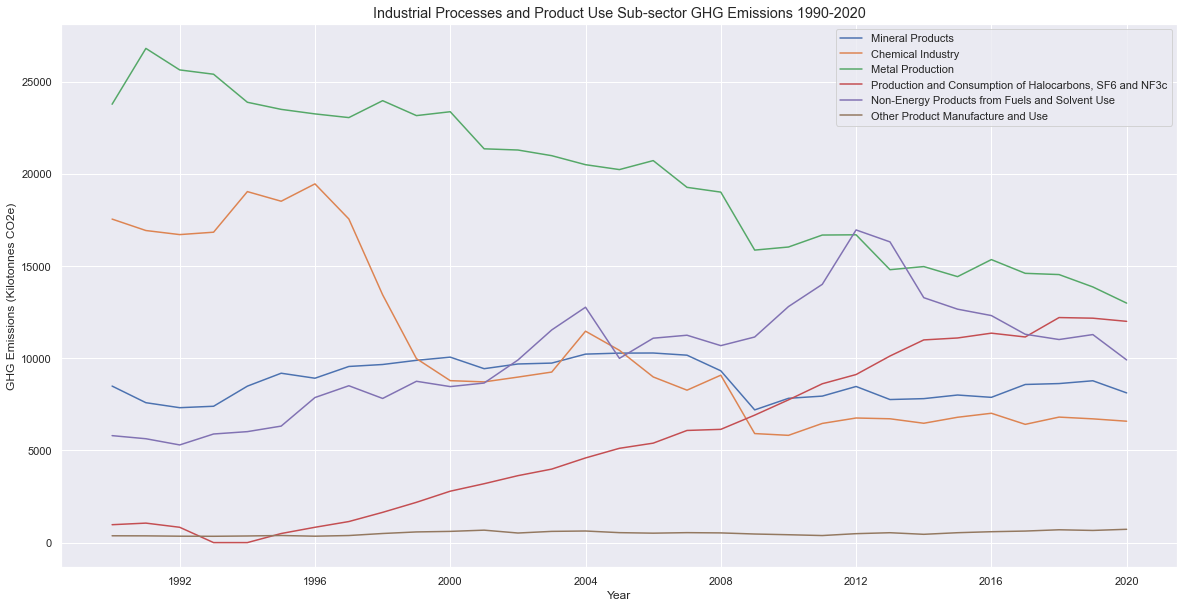

In [105]:
# Industrial Processes Sub-Industries

fig, ax = plt.subplots(figsize=(20,10))
cols_en = list(industrial_sub.columns)
for n in range(len(cols_en)):
    ax.plot(industrial_sub.iloc[:, n], label=cols_en[n])
ax.set_xlabel('Year')
ax.set_ylabel('GHG Emissions (Kilotonnes CO2e)')
plt.legend()
plt.title(label='Industrial Processes and Product Use Sub-sector GHG Emissions 1990-2020', fontsize='large')
plt.show();

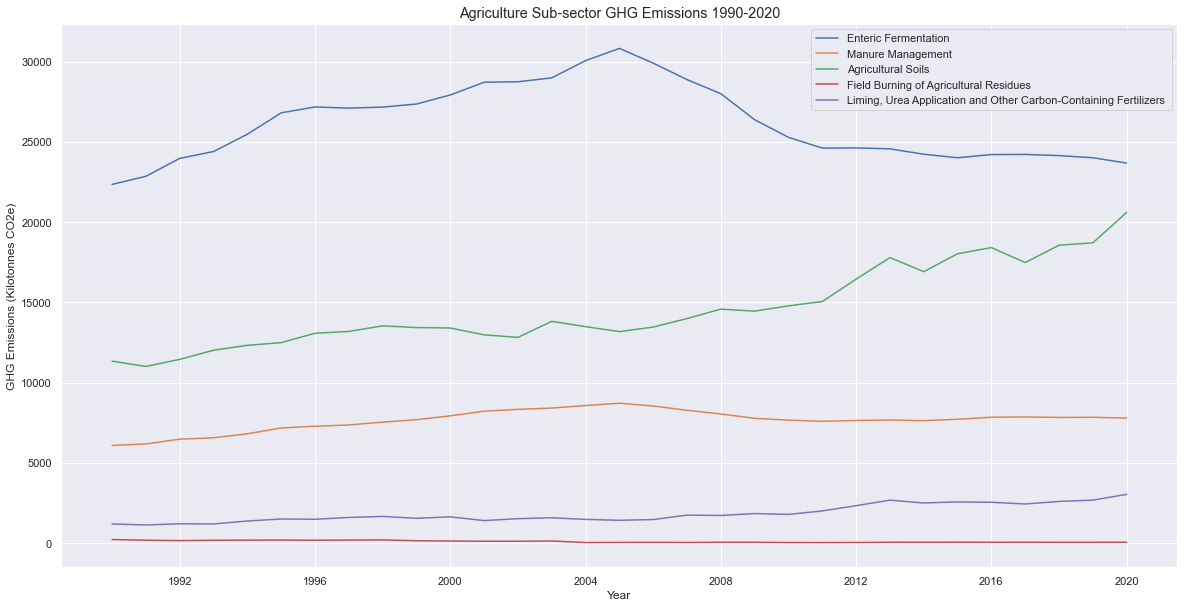

In [106]:
# Agriculture Sub-Industries

fig, ax = plt.subplots(figsize=(20,10))
cols_en = list(agriculture_sub.columns)
for n in range(len(cols_en)):
    ax.plot(agriculture_sub.iloc[:, n], label=cols_en[n])
ax.set_xlabel('Year')
ax.set_ylabel('GHG Emissions (Kilotonnes CO2e)')
plt.legend()
plt.title(label='Agriculture Sub-sector GHG Emissions 1990-2020', fontsize='large')
plt.show();

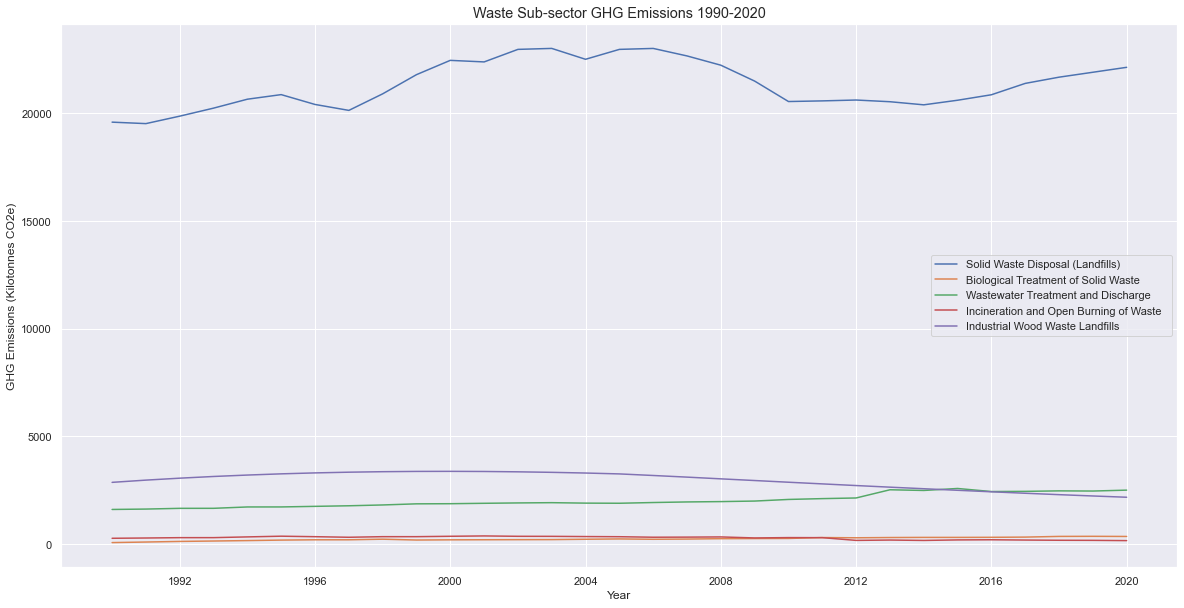

In [107]:
# Waste Sub-industries

fig, ax = plt.subplots(figsize=(20,10))
cols_en = list(waste_sub.columns)
for n in range(len(cols_en)):
    ax.plot(waste_sub.iloc[:, n], label=cols_en[n])
ax.set_xlabel('Year')
ax.set_ylabel('GHG Emissions (Kilotonnes CO2e)')
plt.legend()
plt.title(label='Waste Sub-sector GHG Emissions 1990-2020', fontsize='large')
plt.show();

In [343]:
values = main_industries.values
train = values[:26]
test = values[26:]
print(len(train), len(test))

26 5


In [344]:
scaler = MinMaxScaler()
scaler.fit_transform(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train

array([[0.05431022, 0.71766226, 0.        , 0.        ],
       [0.        , 0.8255814 , 0.01262218, 0.02053249],
       [0.11002104, 0.65549476, 0.15916263, 0.13673285],
       [0.11701128, 0.63505092, 0.24336181, 0.24323105],
       [0.22017639, 0.78058976, 0.38366813, 0.37815884],
       [0.31213026, 0.82710138, 0.53690449, 0.4517148 ],
       [0.42936538, 1.        , 0.61633187, 0.36259025],
       [0.53219153, 0.96359629, 0.63503425, 0.308213  ],
       [0.58294588, 0.72260222, 0.68621565, 0.50789711],
       [0.67660094, 0.53404773, 0.69152621, 0.71412455],
       [0.83103203, 0.49870801, 0.75656123, 0.87251805],
       [0.78624465, 0.34359325, 0.78857847, 0.86349278],
       [0.80740082, 0.49414805, 0.79642885, 0.99210289],
       [0.90646005, 0.65283478, 0.90364042, 1.        ],
       [0.89167375, 0.9622283 , 0.95774648, 0.87522563],
       [0.8827457 , 0.68954248, 1.        , 0.97021661],
       [0.84306189, 0.71948624, 0.94212268, 0.96231949],
       [1.        , 0.6125551 ,

In [345]:
ts = TimeseriesGenerator(scaled_train, scaled_train, length=5, batch_size=1)
ts[0]

(array([[[0.05431022, 0.71766226, 0.        , 0.        ],
         [0.        , 0.8255814 , 0.01262218, 0.02053249],
         [0.11002104, 0.65549476, 0.15916263, 0.13673285],
         [0.11701128, 0.63505092, 0.24336181, 0.24323105],
         [0.22017639, 0.78058976, 0.38366813, 0.37815884]]]),
 array([[0.31213026, 0.82710138, 0.53690449, 0.4517148 ]]))

# RNN

In [347]:
n_features = 4
n_input = 5

model_rnn = Sequential()

#Vanilla RNN model

model_rnn.add(SimpleRNN(50, activation='relu', input_shape=(n_input, n_features)
#, return_sequences=True
))

# Dense = 4 to return predictions for each variable
model_rnn.add(Dense(n_features))
model_rnn.compile(optimizer='adam', loss='mae')

model_rnn.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_39 (SimpleRNN)   (None, 50)                2750      
                                                                 
 dense_35 (Dense)            (None, 4)                 204       
                                                                 
Total params: 2,954
Trainable params: 2,954
Non-trainable params: 0
_________________________________________________________________


In [348]:
es = EarlyStopping(monitor='loss', patience=3)
history = model_rnn.fit(ts, epochs=100, callbacks=[es])

Epoch 1/100
21/21 [==============================] - 1s 3ms/step - loss: 0.4951
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1898
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1521
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1425
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1511
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1354
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1218
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1235
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1260
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1054
Epoch 11/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0997
Epoch 12/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1039
Epoch 13/100
21/21 [=================

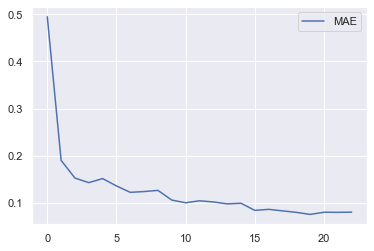

In [349]:
plt.plot(history.history['loss'], label='MAE')
plt.legend()
plt.show();

In [350]:
# Function to create clean test sets for evaluating models

def create_test_sets(length=len(train)):
    en_test = pd.DataFrame(energy[length:])
    in_test = pd.DataFrame(industry[length:])
    ag_test = pd.DataFrame(agriculture[length:])
    wa_test = pd.DataFrame(waste[length:])

    return en_test, in_test, ag_test, wa_test

In [351]:
rnn_predictions = []

current_data = scaled_train[-n_input:].reshape(1,n_input,4)

current_data

for i in range(n_input):
    
    current_prediction = model_rnn.predict(current_data)[0]
    
    rnn_predictions.append(current_prediction)
    
    current_data = np.append(current_data[:,1:,:],[[current_prediction]],axis=1)

test_preds_rnn = np.array(rnn_predictions)
test_preds_rnn = test_preds_rnn.reshape(n_input,4)

# Inverting MinMaxScaling
inverse_test_preds_rnn = scaler.inverse_transform(test_preds_rnn)

# Create test sets for modelling and evaluation
en_test, in_test, ag_test, wa_test = create_test_sets()

en_test['en_preds_rnn'] = pd.DataFrame([x[0] for x in inverse_test_preds_rnn], index=pd.date_range(start=f'{2020-(n_input-1)}-01-01', end='2020-01-01', freq='YS'))
in_test['in_preds_rnn'] = pd.DataFrame([x[1] for x in inverse_test_preds_rnn], index=pd.date_range(start=f'{2020-(n_input-1)}-01-01', end='2020-01-01', freq='YS'))
ag_test['ag_preds_rnn'] = pd.DataFrame([x[2] for x in inverse_test_preds_rnn], index=pd.date_range(start=f'{2020-(n_input-1)}-01-01', end='2020-01-01', freq='YS'))
wa_test['wa_preds_rnn'] = pd.DataFrame([x[3] for x in inverse_test_preds_rnn], index=pd.date_range(start=f'{2020-(n_input-1)}-01-01', end='2020-01-01', freq='YS'))

en_test

1/1 [==============================] - 0s 27ms/step


,ENERGY,en_preds_rnn
Year,,
2016-01-01,581268,591081.3125
2017-01-01,593568,587978.5625
2018-01-01,605942,587336.0000
2019-01-01,604376,581806.2500
2020-01-01,539519,580224.5625


In [352]:
# Checking RMSE for each variable

print(f"Energy Test RMSE: {np.sqrt(mean_squared_error(en_test['ENERGY'],en_test['en_preds_rnn']))}")
print(f"Industry Test RMSE: {np.sqrt(mean_squared_error(in_test['INDUSTRIAL PROCESSES AND PRODUCT USE'],in_test['in_preds_rnn']))}")
print(f"Agriculture Test RMSE: {np.sqrt(mean_squared_error(ag_test['AGRICULTURE'],ag_test['ag_preds_rnn']))}")
print(f"Waste Test RMSE: {np.sqrt(mean_squared_error(wa_test['WASTE'],wa_test['wa_preds_rnn']))}")

Energy Test RMSE: 22978.522943361564
Industry Test RMSE: 1731.4171246885935
Agriculture Test RMSE: 1267.9075053622526
Waste Test RMSE: 289.92941675120323


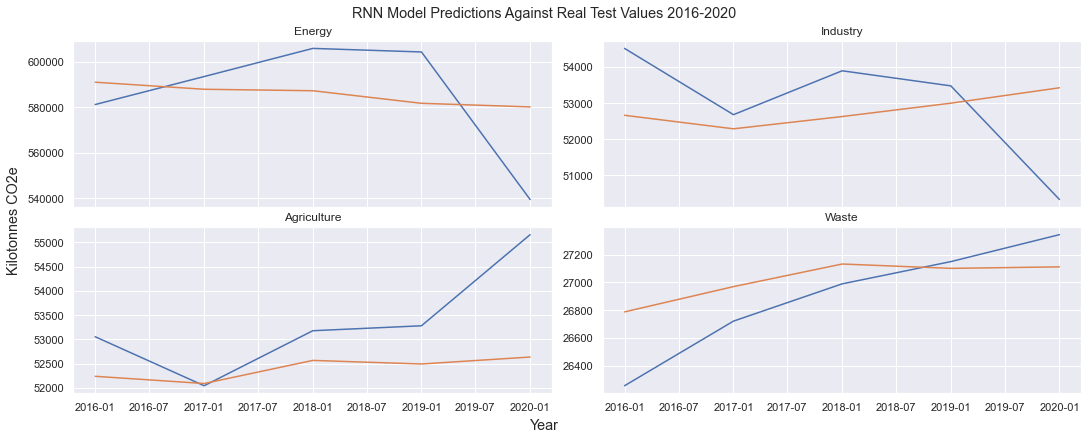

In [353]:
# Plotting predictions against test data

fig,axs = plt.subplots(2,2, figsize=(15,6), sharex=True, constrained_layout=True)

fig.suptitle(f'RNN Model Predictions Against Real Test Values {2020-(n_input-1)}-2020', fontsize='large')
fig.supxlabel('Year')
fig.supylabel('Kilotonnes CO2e')

axs[0,0].plot(en_test)
axs[0,0].set_title('Energy')
axs[0,1].plot(in_test)
axs[0,1].set_title('Industry')
axs[1,0].plot(ag_test)
axs[1,0].set_title('Agriculture')
axs[1,1].plot(wa_test)
axs[1,1].set_title('Waste')

plt.show();

1/1 [==============================] - 0s 25ms/step


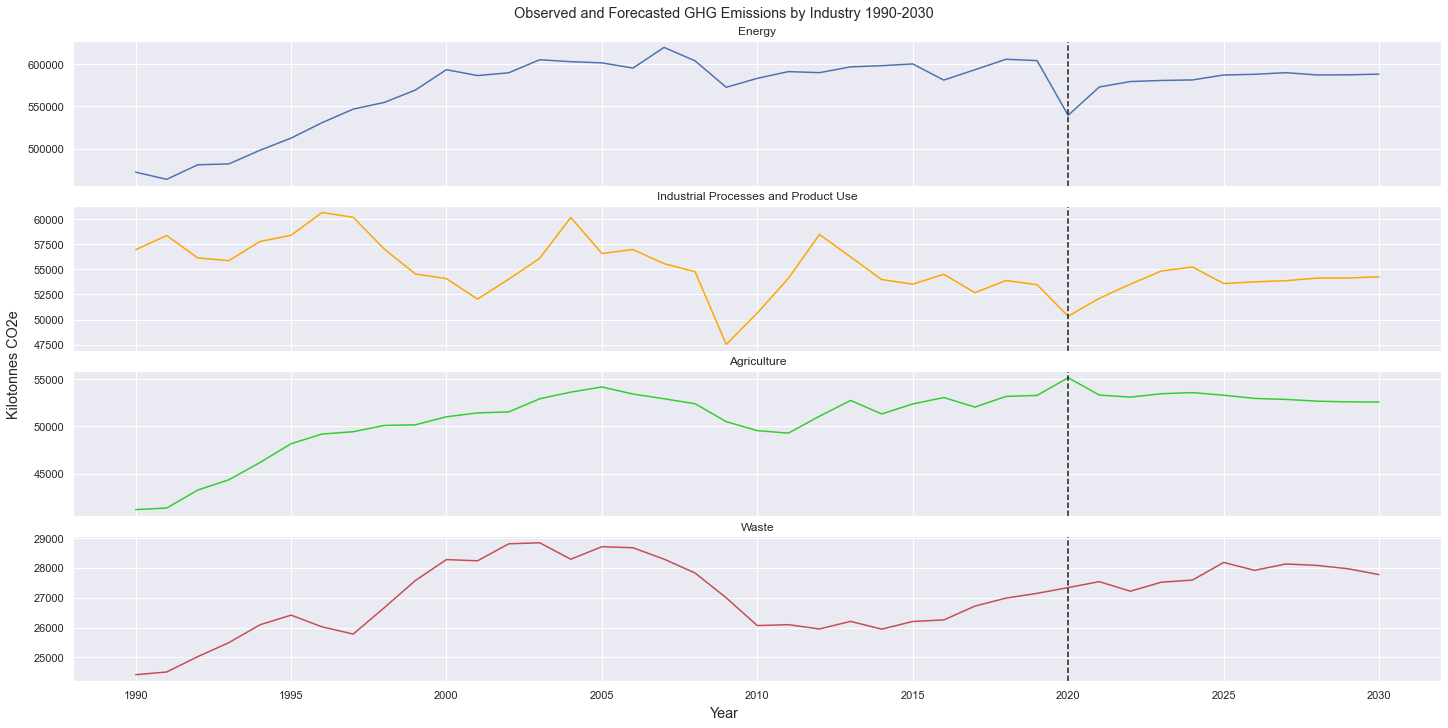

In [354]:
# Creating predictions to 2030

future_preds_rnn = []

current_data = scaled_test.reshape(1,n_input,4)

for i in range(10):

    current_prediction = model_rnn.predict(current_data)

    future_preds_rnn.append(current_prediction)

    current_data = np.append(current_data[:,1:,:],[current_prediction],axis=1)

future_preds_rnn = np.array(future_preds_rnn)
future_preds_rnn = future_preds_rnn.reshape(10,4)

# Inverting MinMaxScaling
inverse_future_preds_rnn = scaler.inverse_transform(future_preds_rnn)
inverse_future_preds_rnn

# Plotting predictions

future_df_rnn = pd.DataFrame(inverse_future_preds_rnn, index=pd.date_range(start='2021-01-01', end='2030-01-01', freq='YS'), columns = main_industries.columns)

combined_df = main_industries.append(future_df_rnn)

fig,(ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(20,10), sharex=True, constrained_layout=True)

fig.suptitle('Observed and Forecasted GHG Emissions by Industry 1990-2030', fontsize='large')
fig.supxlabel('Year')
fig.supylabel('Kilotonnes CO2e')

ax1.plot(combined_df.iloc[:, 0], color='b')
ax1.set_title('Energy')
ax1.axvline(x=18262.0, color='k', linestyle='--')
ax2.plot(combined_df.iloc[:, 1], color='orange')
ax2.set_title('Industrial Processes and Product Use')
ax2.axvline(x=18262.0, color='k', linestyle='--')
ax3.plot(combined_df.iloc[:, 2], color='limegreen')
ax3.set_title('Agriculture')
ax3.axvline(x=18262.0, color='k', linestyle='--')
ax4.plot(combined_df.iloc[:, 3], color='r')
ax4.set_title('Waste')
ax4.axvline(x=18262.0, color='k', linestyle='--')

locs, labels = plt.xticks()
plt.show();

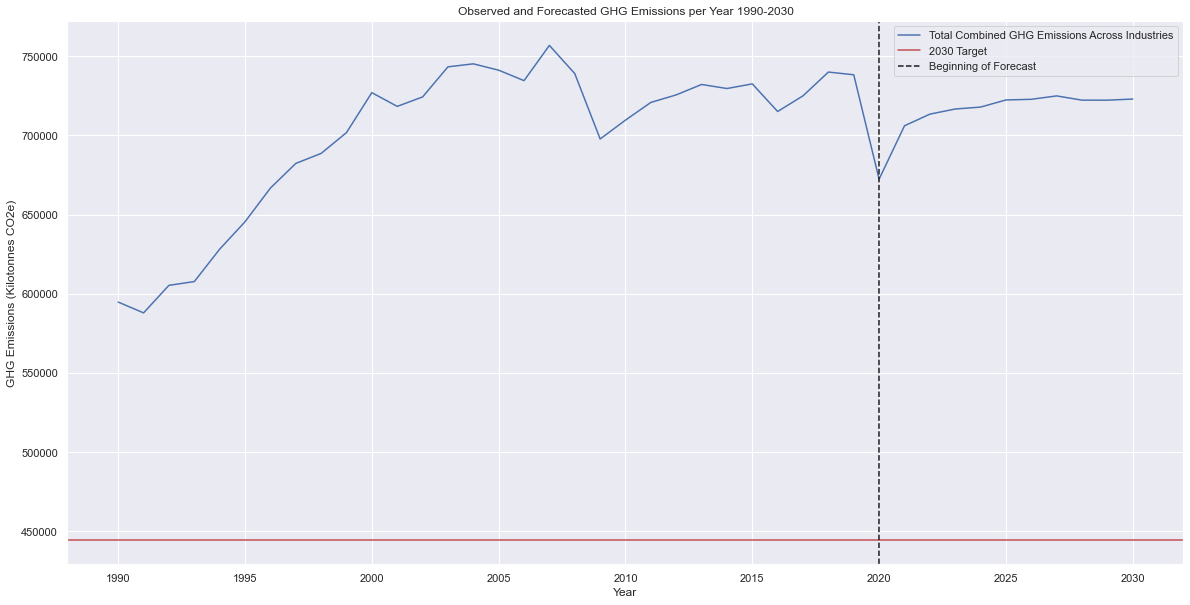

In [355]:
forecast_total = combined_df.sum(axis=1)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(forecast_total, label='Total Combined GHG Emissions Across Industries')
plt.axhline(y=(data.TOTAL[15]*0.60), color='r', linestyle = '-', label='2030 Target')
plt.title(label='Observed and Forecasted GHG Emissions per Year 1990-2030')
ax.set_xlabel('Year')
ax.set_ylabel('GHG Emissions (Kilotonnes CO2e)')
ax.axvline(x=18262.0, color='k', linestyle='--', label='Beginning of Forecast')
plt.legend()
plt.show();

Quality results on the model predictions, and though the plots against the test data could be tighter, it still seems to follow the general trend of the data.

# LSTM

In [356]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))

model_lstm.add(Dense(n_features))
model_lstm.compile(optimizer='adam', loss='mae')

model_lstm.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                11000     
                                                                 
 dense_36 (Dense)            (None, 4)                 204       
                                                                 
Total params: 11,204
Trainable params: 11,204
Non-trainable params: 0
_________________________________________________________________


In [357]:
es = EarlyStopping(monitor='loss', patience=3)
history = model_lstm.fit(ts, epochs=100, callbacks=[es])

Epoch 1/100
21/21 [==============================] - 2s 4ms/step - loss: 0.5127
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 0.2862
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1873
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1641
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1561
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1473
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1504
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1444
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1547
Epoch 10/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1430
Epoch 11/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1411
Epoch 12/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1378
Epoch 13/100
21/21 [=================

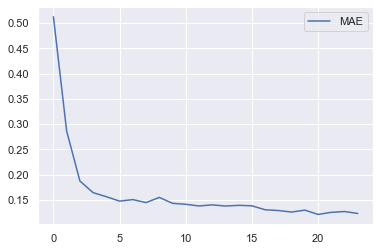

In [358]:
# Plotting loss
plt.plot(history.history['loss'], label='MAE')
plt.legend()
plt.show();

In [359]:
lstm_predictions = []

current_data = scaled_train[-n_input:].reshape(1,n_input,4)

current_data

for i in range(n_input):
    
    current_prediction = model_lstm.predict(current_data)[0]
    
    lstm_predictions.append(current_prediction)
    
    current_data = np.append(current_data[:,1:,:],[[current_prediction]],axis=1)

test_preds_lstm = np.array(lstm_predictions)
test_preds_lstm = test_preds_lstm.reshape(n_input,4)

# Inverting MinMaxScaling
inverse_test_preds_lstm = scaler.inverse_transform(test_preds_lstm)

en_test, in_test, ag_test, wa_test = create_test_sets()

en_test['en_preds_lstm'] = pd.DataFrame([x[0] for x in inverse_test_preds_lstm], index=pd.date_range(start='2016-01-01', end=f'{2016 + (n_input-1)}-01-01', freq='YS'))
in_test['in_preds_lstm'] = pd.DataFrame([x[1] for x in inverse_test_preds_lstm], index=pd.date_range(start='2016-01-01', end=f'{2016 + (n_input-1)}-01-01', freq='YS'))
ag_test['ag_preds_lstm'] = pd.DataFrame([x[2] for x in inverse_test_preds_lstm], index=pd.date_range(start='2016-01-01', end=f'{2016 + (n_input-1)}-01-01', freq='YS'))
wa_test['wa_preds_lstm'] = pd.DataFrame([x[3] for x in inverse_test_preds_lstm], index=pd.date_range(start='2016-01-01', end=f'{2016 + (n_input-1)}-01-01', freq='YS'))

en_test

1/1 [==============================] - 0s 26ms/step


,ENERGY,en_preds_lstm
Year,,
2016-01-01,581268,595533.8750
2017-01-01,593568,597194.8750
2018-01-01,605942,596956.8125
2019-01-01,604376,596456.2500
2020-01-01,539519,597302.9375


In [360]:
print(f"Energy Test RMSE: {np.sqrt(mean_squared_error(en_test['ENERGY'],en_test['en_preds_lstm']))}")
print(f"Industry Test RMSE: {np.sqrt(mean_squared_error(in_test['INDUSTRIAL PROCESSES AND PRODUCT USE'],in_test['in_preds_lstm']))}")
print(f"Agriculture Test RMSE: {np.sqrt(mean_squared_error(ag_test['AGRICULTURE'],ag_test['ag_preds_lstm']))}")
print(f"Waste Test RMSE: {np.sqrt(mean_squared_error(wa_test['WASTE'],wa_test['wa_preds_lstm']))}")

Energy Test RMSE: 27199.66499520835
Industry Test RMSE: 1934.4920285981323
Agriculture Test RMSE: 1499.788069138951
Waste Test RMSE: 415.64151272982775


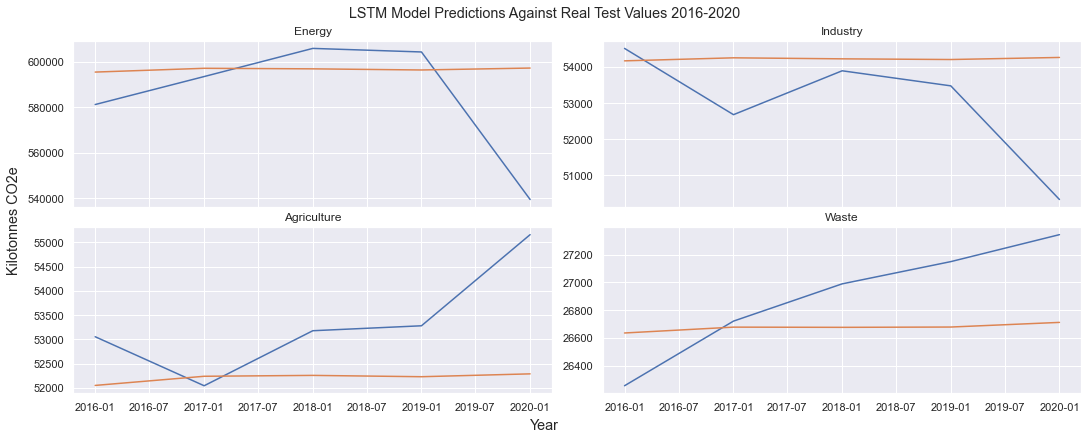

In [361]:
fig,axs = plt.subplots(2,2, figsize=(15,6), sharex=True, constrained_layout=True)

fig.suptitle('LSTM Model Predictions Against Real Test Values 2016-2020', fontsize='large')
fig.supxlabel('Year')
fig.supylabel('Kilotonnes CO2e')

axs[0,0].plot(en_test)
axs[0,0].set_title('Energy')
axs[0,1].plot(in_test)
axs[0,1].set_title('Industry')
axs[1,0].plot(ag_test)
axs[1,0].set_title('Agriculture')
axs[1,1].plot(wa_test)
axs[1,1].set_title('Waste')

plt.show();

1/1 [==============================] - 0s 27ms/step


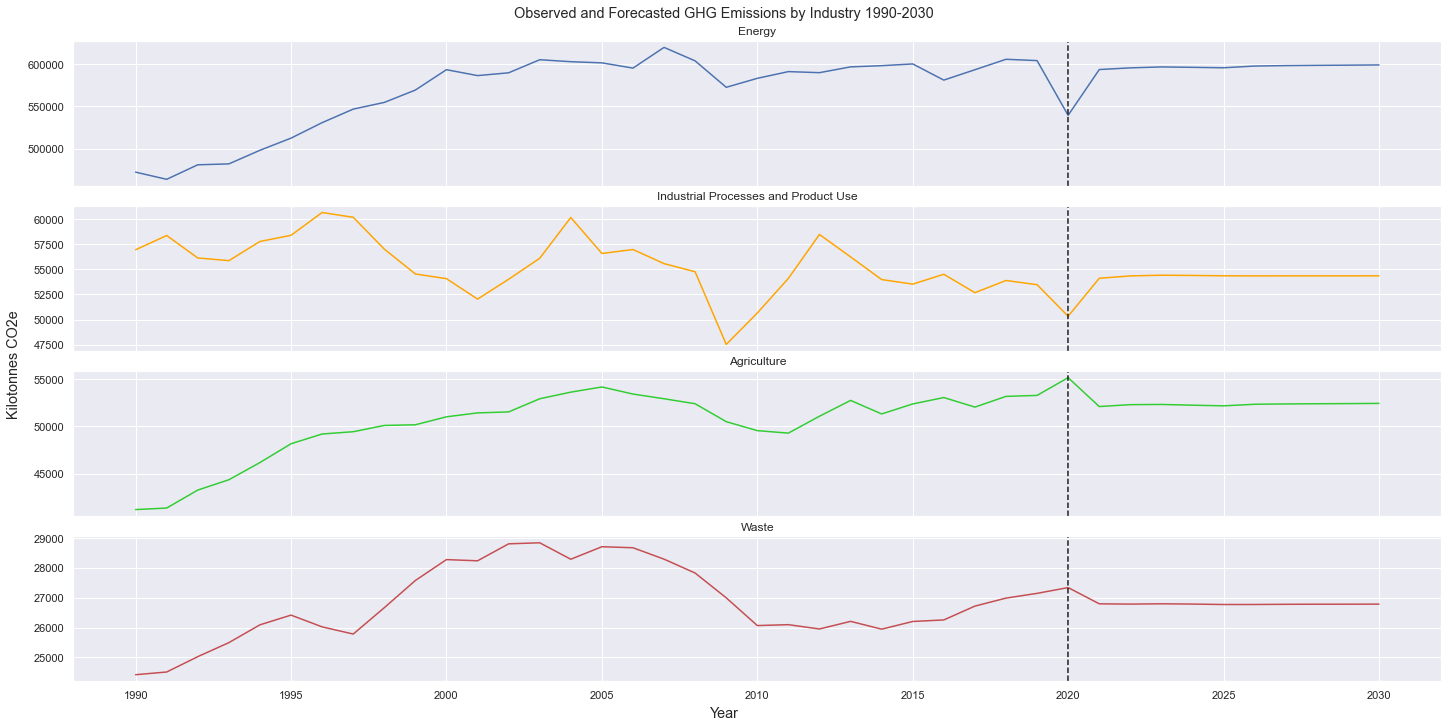

In [362]:
# Creating predictions to 2030

future_preds_lstm = []

current_data = scaled_test.reshape(1,5,4)

for i in range(10):

    current_prediction = model_lstm.predict(current_data)

    future_preds_lstm.append(current_prediction)

    current_data = np.append(current_data[:,1:,:],[current_prediction],axis=1)

future_preds_lstm = np.array(future_preds_lstm)
future_preds_lstm = future_preds_lstm.reshape(10,4)

# Inverting MinMaxScaling
inverse_future_preds_lstm = scaler.inverse_transform(future_preds_lstm)
inverse_future_preds_lstm

# Plotting predictions

future_df_lstm = pd.DataFrame(inverse_future_preds_lstm, index=pd.date_range(start='2021-01-01', end='2030-01-01', freq='YS'), columns = main_industries.columns)

combined_df = main_industries.append(future_df_lstm)

fig,(ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(20,10), sharex=True, constrained_layout=True)

fig.suptitle('Observed and Forecasted GHG Emissions by Industry 1990-2030', fontsize='large')
fig.supxlabel('Year')
fig.supylabel('Kilotonnes CO2e')

ax1.plot(combined_df.iloc[:, 0], color='b')
ax1.set_title('Energy')
ax1.axvline(x=18262.0, color='k', linestyle='--')
ax2.plot(combined_df.iloc[:, 1], color='orange')
ax2.set_title('Industrial Processes and Product Use')
ax2.axvline(x=18262.0, color='k', linestyle='--')
ax3.plot(combined_df.iloc[:, 2], color='limegreen')
ax3.set_title('Agriculture')
ax3.axvline(x=18262.0, color='k', linestyle='--')
ax4.plot(combined_df.iloc[:, 3], color='r')
ax4.set_title('Waste')
ax4.axvline(x=18262.0, color='k', linestyle='--')

locs, labels = plt.xticks()
plt.show();


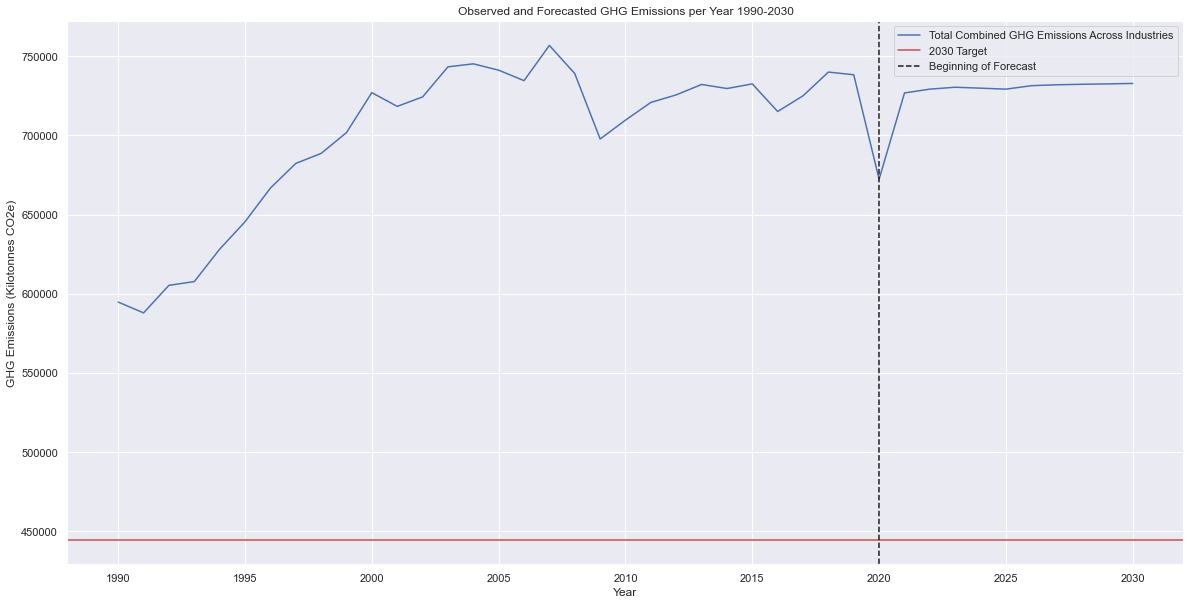

In [363]:
# Plotting combined predictions

forecast_total = combined_df.sum(axis=1)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(forecast_total, label='Total Combined GHG Emissions Across Industries')
plt.axhline(y=(data.TOTAL[15]*0.60), color='r', linestyle = '-', label='2030 Target')
plt.title(label='Observed and Forecasted GHG Emissions per Year 1990-2030')
ax.set_xlabel('Year')
ax.set_ylabel('GHG Emissions (Kilotonnes CO2e)')
ax.axvline(x=18262.0, color='k', linestyle='--', label='Beginning of Forecast')
plt.legend()
plt.show();

A complete failure in terms of guaging the direction of the data. Is basically only capable of predicting a single number regardless of the input data.

# GRU

In [364]:
model_gru = Sequential()

model_gru.add(GRU(50, activation='relu', input_shape=(n_input, n_features)))

model_gru.add(Dense(n_features))
model_gru.compile(optimizer='adam', loss='mae')

model_gru.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 50)                8400      
                                                                 
 dense_37 (Dense)            (None, 4)                 204       
                                                                 
Total params: 8,604
Trainable params: 8,604
Non-trainable params: 0
_________________________________________________________________


In [365]:
es = EarlyStopping(monitor='loss', patience=3)
history = model_gru.fit(ts, epochs=100, callbacks=[es])

Epoch 1/100
21/21 [==============================] - 2s 5ms/step - loss: 0.5842
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 0.2268
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1632
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1474
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1401
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1343
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1427
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1292
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1283
Epoch 10/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1231
Epoch 11/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1245
Epoch 12/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1219
Epoch 13/100
21/21 [=================

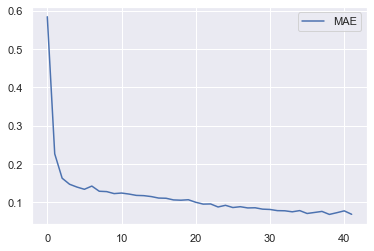

In [366]:
plt.plot(history.history['loss'], label='MAE')
plt.legend()
plt.show();

In [367]:
gru_predictions = []

current_data = scaled_train[-n_input:].reshape(1,n_input,4)

current_data

for i in range(n_input):
    
    current_prediction = model_gru.predict(current_data)[0]
    
    gru_predictions.append(current_prediction)
    
    current_data = np.append(current_data[:,1:,:],[[current_prediction]],axis=1)

test_preds_gru = np.array(gru_predictions)
test_preds_gru = test_preds_gru.reshape(n_input,4)

# Inverting MinMaxScaling
inverse_test_preds_gru = scaler.inverse_transform(test_preds_gru)

en_test, in_test, ag_test, wa_test = create_test_sets()

en_test['en_preds_gru'] = pd.DataFrame([x[0] for x in inverse_test_preds_gru], index=pd.date_range(start=f'{2020-(n_input-1)}-01-01', end='2020-01-01', freq='YS'))
in_test['in_preds_gru'] = pd.DataFrame([x[1] for x in inverse_test_preds_gru], index=pd.date_range(start=f'{2020-(n_input-1)}-01-01', end='2020-01-01', freq='YS'))
ag_test['ag_preds_gru'] = pd.DataFrame([x[2] for x in inverse_test_preds_gru], index=pd.date_range(start=f'{2020-(n_input-1)}-01-01', end='2020-01-01', freq='YS'))
wa_test['wa_preds_gru'] = pd.DataFrame([x[3] for x in inverse_test_preds_gru], index=pd.date_range(start=f'{2020-(n_input-1)}-01-01', end='2020-01-01', freq='YS'))

en_test

1/1 [==============================] - 0s 26ms/step


,ENERGY,en_preds_gru
Year,,
2016-01-01,581268,602037.8750
2017-01-01,593568,604960.5625
2018-01-01,605942,607485.0625
2019-01-01,604376,608384.4375
2020-01-01,539519,609075.3750


In [368]:
print(f"Energy Test RMSE: {np.sqrt(mean_squared_error(en_test['ENERGY'],en_test['en_preds_gru']))}")
print(f"Industry Test RMSE: {np.sqrt(mean_squared_error(in_test['INDUSTRIAL PROCESSES AND PRODUCT USE'],in_test['in_preds_gru']))}")
print(f"Agriculture Test RMSE: {np.sqrt(mean_squared_error(ag_test['AGRICULTURE'],ag_test['ag_preds_gru']))}")
print(f"Waste Test RMSE: {np.sqrt(mean_squared_error(wa_test['WASTE'],wa_test['wa_preds_gru']))}")

Energy Test RMSE: 32917.21769543401
Industry Test RMSE: 1838.6043045040033
Agriculture Test RMSE: 1733.8572829344516
Waste Test RMSE: 632.3020875911105


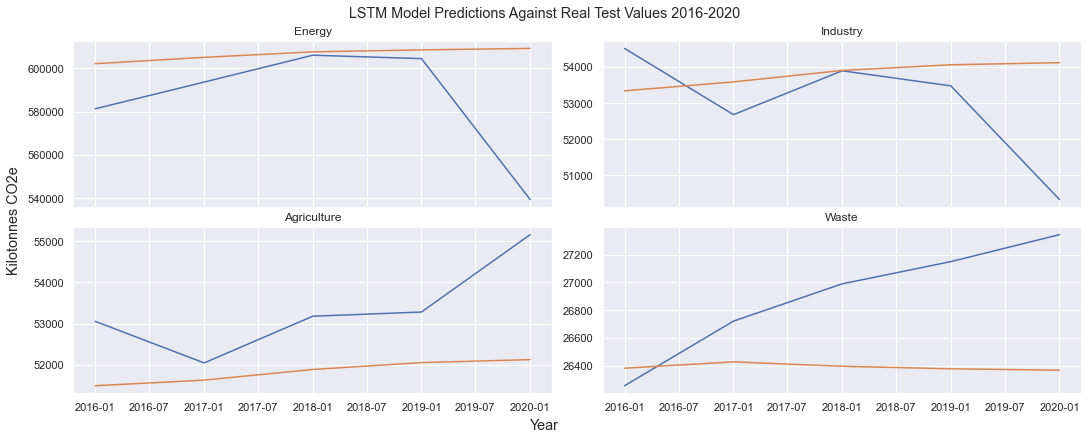

In [369]:
fig,axs = plt.subplots(2,2, figsize=(15,6), sharex=True, constrained_layout=True)

fig.suptitle(f'LSTM Model Predictions Against Real Test Values {2020-(n_input-1)}-2020', fontsize='large')
fig.supxlabel('Year')
fig.supylabel('Kilotonnes CO2e')

axs[0,0].plot(en_test)
axs[0,0].set_title('Energy')
axs[0,1].plot(in_test)
axs[0,1].set_title('Industry')
axs[1,0].plot(ag_test)
axs[1,0].set_title('Agriculture')
axs[1,1].plot(wa_test)
axs[1,1].set_title('Waste')

plt.show();

1/1 [==============================] - 0s 28ms/step


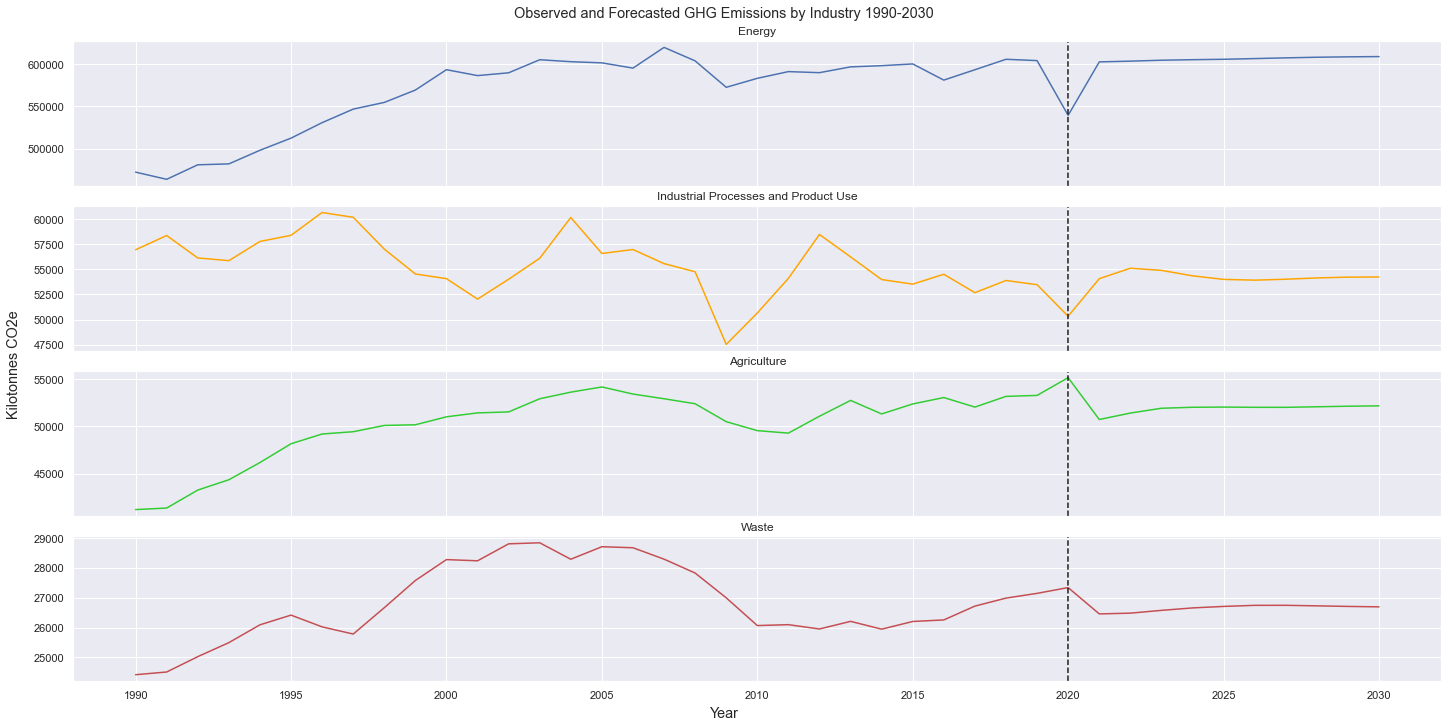

In [370]:
# Creating predictions to 2030

future_preds_gru = []

current_data = scaled_test.reshape(1,n_input,4)

for i in range(10):

    current_prediction = model_gru.predict(current_data)

    future_preds_gru.append(current_prediction)

    current_data = np.append(current_data[:,1:,:],[current_prediction],axis=1)

future_preds_gru = np.array(future_preds_gru)
future_preds_gru = future_preds_gru.reshape(10,4)

# Inverting MinMaxScaling
inverse_future_preds_gru = scaler.inverse_transform(future_preds_gru)
inverse_future_preds_gru

# Plotting predictions

future_df_gru = pd.DataFrame(inverse_future_preds_gru, index=pd.date_range(start='2021-01-01', end='2030-01-01', freq='YS'), columns = main_industries.columns)

combined_df = main_industries.append(future_df_gru)

fig,(ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(20,10), sharex=True, constrained_layout=True)

fig.suptitle('Observed and Forecasted GHG Emissions by Industry 1990-2030', fontsize='large')
fig.supxlabel('Year')
fig.supylabel('Kilotonnes CO2e')

ax1.plot(combined_df.iloc[:, 0], color='b')
ax1.set_title('Energy')
ax1.axvline(x=18262.0, color='k', linestyle='--')
ax2.plot(combined_df.iloc[:, 1], color='orange')
ax2.set_title('Industrial Processes and Product Use')
ax2.axvline(x=18262.0, color='k', linestyle='--')
ax3.plot(combined_df.iloc[:, 2], color='limegreen')
ax3.set_title('Agriculture')
ax3.axvline(x=18262.0, color='k', linestyle='--')
ax4.plot(combined_df.iloc[:, 3], color='r')
ax4.set_title('Waste')
ax4.axvline(x=18262.0, color='k', linestyle='--')

locs, labels = plt.xticks()
plt.show();

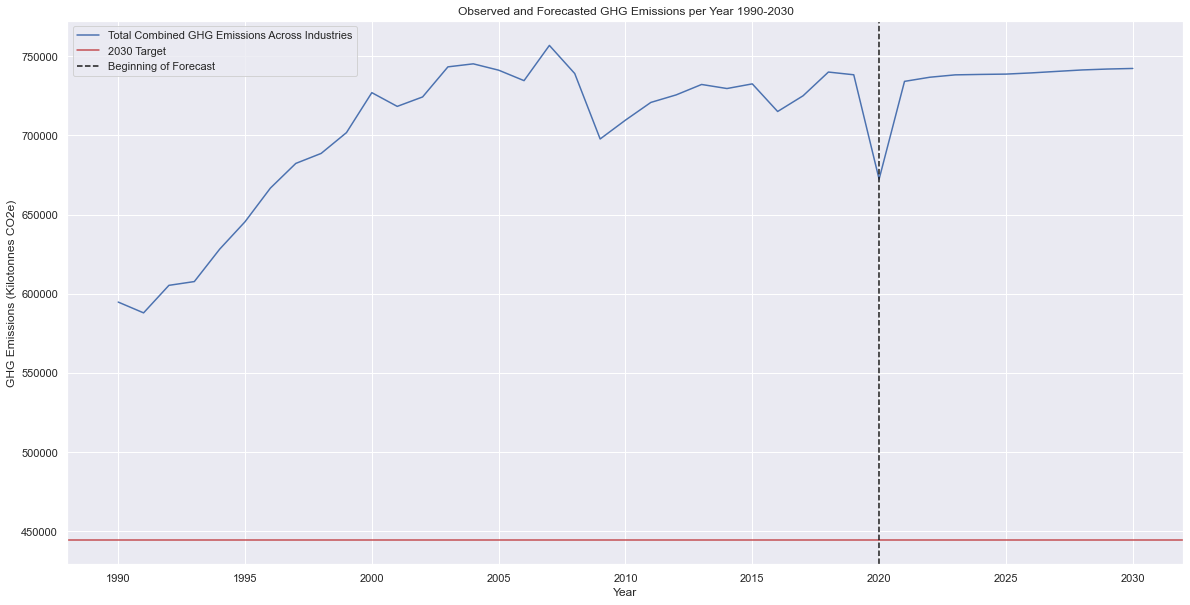

In [371]:
forecast_total = combined_df.sum(axis=1)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(forecast_total, label='Total Combined GHG Emissions Across Industries')
plt.axhline(y=(data.TOTAL[15]*0.60), color='r', linestyle = '-', label='2030 Target')
plt.title(label='Observed and Forecasted GHG Emissions per Year 1990-2030')
ax.set_xlabel('Year')
ax.set_ylabel('GHG Emissions (Kilotonnes CO2e)')
ax.axvline(x=18262.0, color='k', linestyle='--', label='Beginning of Forecast')
plt.legend()
plt.show();

A definite improvement over LSTM by exhibiting some difference over time, but still exhibits flattening of the values over the forecast.

## Conclusions

Comparing the three RNN models and running numerous iterations of each shows a definite advantage for the SimpleRNN model compared to the LSTM or GRU models. The average RMSE for each variable was lower, and the forecasted predictions followed a more realistic trajectory than the LSTM or GRU, which would flatten after an initial spike generated by the test data.

Regardless of the modelling technique used, each variation predicted that there is still a significant gap to overcome if Canada is to meet its 2030 Net Zero target. Most of the efforts should be focused on the creation of green energy where renewables are not currently available, such as in large smelting facilities, for example. 